In [34]:
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd

#from sklearn import OneHotEncoder

# per importare cose nella folder precedente da ora in poi
import sys
sys.path.append('../')

from layer import HiddenLayer
from activations import *
from losses import *
from network import Network
from regularizers import *
from utils import *
from metrics import *
from validation import *

random.seed(42)
np.random.seed(42)

# Progress bar
from tqdm import tqdm
import time

In [35]:
X_train, y_train, test = read_cup("../data/ML-CUP23-TR.csv", "../data/ML-CUP23-TS.csv")

In [ ]:
seed = 3
np.random.seed(seed)
net = Network(MSE(1), eta=1e-4)

net.add_layer(
    input_size=len(X_train[0]),
    units_size=16,
    starting=Range_random(),
    regularizer=L2(lambda_=1e-6),
    activation=ReLU(),
    momentum=('Standard',1e-5)
)


net.add_layer(
    input_size=16,
    units_size=16,
    starting=Range_random(),
    regularizer=L2(lambda_=1e-6),
    activation=Identity(),
    momentum=('Standard',1e-5)
)
net.add_layer(
    input_size=16,
    units_size=3,
    starting=Range_random(),
    regularizer=L2(lambda_=1e-6),
    activation=Identity(),
    momentum=('Standard',1e-5)
)

In [ ]:
seed = 3

net = create_all_net(
    seed=seed,
    loss="MSE",
    batch_size=1,
    input_size=len(X_train[0]),
    num_layer=3,
    layers_size=[16,16,3],
    starting=["Range_random", "Range_random", "Range_random"],
    starting_range=[(-0.5,0.5),(-0.5,0.5),(-0.5,0.5)],
    activations=["ReLU", "ReLU", "Identity"],
    regularizers=["L2", "None", "L2"],
    regularizers_lambda=[1e-6,0,1e-6],
    momentums=[("Standard", 1e-5), ("None", 0), ("Standard", 1e-5)],
    eta=1e-4
)

In [ ]:

regularizers=["L2", "None", "L2"]
regularizers_lambda=[1e-6,0,1e-6]
regularizers_ = []

for i, reg in enumerate(regularizers):
    print(reg)
    if reg != "None":
        regularizers_.append(eval(reg)(lambda_=regularizers_lambda[i]))
    else:
        regularizers_.append(None)

for i in regularizers_:
    print(type(i))

In [ ]:
print(net)
type(net.loss)


In [ ]:
statistics = kfold_crossval(
    X=X_train,
    y=y_train,
    k=6,
    net=net,
    epochs=2500,
    patience=100,
    seed=seed,
    metric=MEE()
)

print(statistics)

In [42]:
import itertools

# Define the hyperparameters as dictionaries
hyperparameters = {
    'losses': ["MSE"],
    'layers_sizes': [[32,32,3],[16,16,16,3]],
    'activations': ["ReLU"], 
    'startings': ["Range_random"],
    'startings_range': [(-0.5, 0.5)],
    'regularizers': ["L2"],
    'regularizers_lambda': [1e-6, 1e-8],
    'momentums': [('Nesterov', 1e-4), ('Standard', 1e-4)],
    'etas': [1e-4]
}

# Create a list of all the possible combinations using itertools.product
hyperparameter_combinations = list(itertools.product(*hyperparameters.values()))

all_dics = []
# Print the result or use it as needed
for combination in hyperparameter_combinations:
    hyperparameter_dict = dict(zip(hyperparameters.keys(), combination))
    print(hyperparameter_dict)
    all_dics.append(hyperparameter_dict)

{'losses': 'MSE', 'layers_sizes': [32, 32, 3], 'activations': 'ReLU', 'startings': 'Range_random', 'startings_range': (-0.5, 0.5), 'regularizers': 'L2', 'regularizers_lambda': 1e-06, 'momentums': ('Nesterov', 0.0001), 'etas': 0.0001}
{'losses': 'MSE', 'layers_sizes': [32, 32, 3], 'activations': 'ReLU', 'startings': 'Range_random', 'startings_range': (-0.5, 0.5), 'regularizers': 'L2', 'regularizers_lambda': 1e-06, 'momentums': ('Standard', 0.0001), 'etas': 0.0001}
{'losses': 'MSE', 'layers_sizes': [32, 32, 3], 'activations': 'ReLU', 'startings': 'Range_random', 'startings_range': (-0.5, 0.5), 'regularizers': 'L2', 'regularizers_lambda': 1e-08, 'momentums': ('Nesterov', 0.0001), 'etas': 0.0001}
{'losses': 'MSE', 'layers_sizes': [32, 32, 3], 'activations': 'ReLU', 'startings': 'Range_random', 'startings_range': (-0.5, 0.5), 'regularizers': 'L2', 'regularizers_lambda': 1e-08, 'momentums': ('Standard', 0.0001), 'etas': 0.0001}
{'losses': 'MSE', 'layers_sizes': [16, 16, 16, 3], 'activations'

In [43]:
for i in all_dics:
    print(*i.values())

MSE [32, 32, 3] ReLU Range_random (-0.5, 0.5) L2 1e-06 ('Nesterov', 0.0001) 0.0001
MSE [32, 32, 3] ReLU Range_random (-0.5, 0.5) L2 1e-06 ('Standard', 0.0001) 0.0001
MSE [32, 32, 3] ReLU Range_random (-0.5, 0.5) L2 1e-08 ('Nesterov', 0.0001) 0.0001
MSE [32, 32, 3] ReLU Range_random (-0.5, 0.5) L2 1e-08 ('Standard', 0.0001) 0.0001
MSE [16, 16, 16, 3] ReLU Range_random (-0.5, 0.5) L2 1e-06 ('Nesterov', 0.0001) 0.0001
MSE [16, 16, 16, 3] ReLU Range_random (-0.5, 0.5) L2 1e-06 ('Standard', 0.0001) 0.0001
MSE [16, 16, 16, 3] ReLU Range_random (-0.5, 0.5) L2 1e-08 ('Nesterov', 0.0001) 0.0001
MSE [16, 16, 16, 3] ReLU Range_random (-0.5, 0.5) L2 1e-08 ('Standard', 0.0001) 0.0001


In [37]:
losses_ = "MSE"

startings_ = []
startings_range_ = []
activations_ = []
regularizers_ = []
regularizers_lambda_ = []
momentums_ = []


for combination in all_dics:
    layers_sizes_ = combination['layers_sizes']
    startings_ = []
    activations_ = []
    regularizers_ = []
    regularizers_lambda_ = []
    momentums_ = []
    startings_range_ = []
    etas_ = combination['etas']
    for i in range(len(combination['layers_sizes'])):
        activations_.append(combination['activations'] if i != len(layers_sizes_)-1 else "Identity")
        startings_.append(combination['startings'])
        startings_range_.append(combination['startings_range'])
        regularizers_.append(combination['regularizers'])
        regularizers_lambda_.append(combination['regularizers_lambda'])
        momentums_.append(combination['momentums'])
    
    print(layers_sizes_)
    print(activations_)
    print(startings_)
    print(startings_range_)
    print(regularizers_)
    print(regularizers_lambda_)
    print(momentums_)
    print(etas_)
    print("\n")

[32, 32, 3]
['ReLU', 'ReLU', 'Identity']
['Range_random', 'Range_random', 'Range_random']
[(-0.5, 0.5), (-0.5, 0.5), (-0.5, 0.5)]
['L1', 'L1', 'L1']
[1e-06, 1e-06, 1e-06]
[('Nesterov', 0.0001), ('Nesterov', 0.0001), ('Nesterov', 0.0001)]
0.0001


[32, 32, 3]
['ReLU', 'ReLU', 'Identity']
['Range_random', 'Range_random', 'Range_random']
[(-0.5, 0.5), (-0.5, 0.5), (-0.5, 0.5)]
['L2', 'L2', 'L2']
[1e-06, 1e-06, 1e-06]
[('Nesterov', 0.0001), ('Nesterov', 0.0001), ('Nesterov', 0.0001)]
0.0001


[8, 8, 3]
['ReLU', 'ReLU', 'Identity']
['Range_random', 'Range_random', 'Range_random']
[(-0.5, 0.5), (-0.5, 0.5), (-0.5, 0.5)]
['L1', 'L1', 'L1']
[1e-06, 1e-06, 1e-06]
[('Nesterov', 0.0001), ('Nesterov', 0.0001), ('Nesterov', 0.0001)]
0.0001


[8, 8, 3]
['ReLU', 'ReLU', 'Identity']
['Range_random', 'Range_random', 'Range_random']
[(-0.5, 0.5), (-0.5, 0.5), (-0.5, 0.5)]
['L2', 'L2', 'L2']
[1e-06, 1e-06, 1e-06]
[('Nesterov', 0.0001), ('Nesterov', 0.0001), ('Nesterov', 0.0001)]
0.0001




In [ ]:
data_to_csv = [["Loss func","Size", "Activation", "Starting", "Range", "Regularizer", "lambda", "Momentum", "Eta", "tLoss", "tMetric", "vLoss", "vMetric"]]

Epochs:  23%|██▎       | 2256/10000 [01:51<06:23, 20.22it/s]


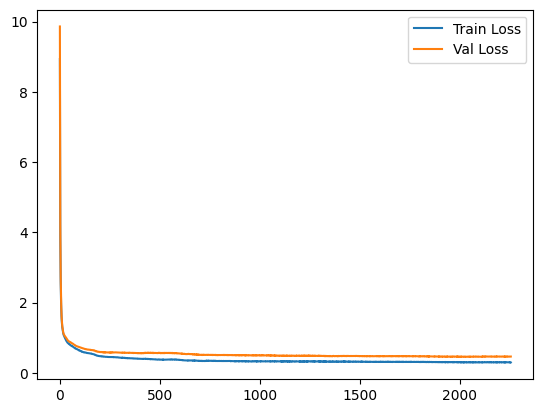

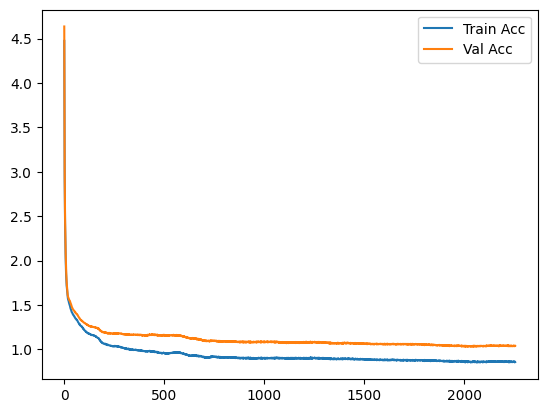

Epochs:   9%|▉         | 884/10000 [00:35<06:09, 24.65it/s]


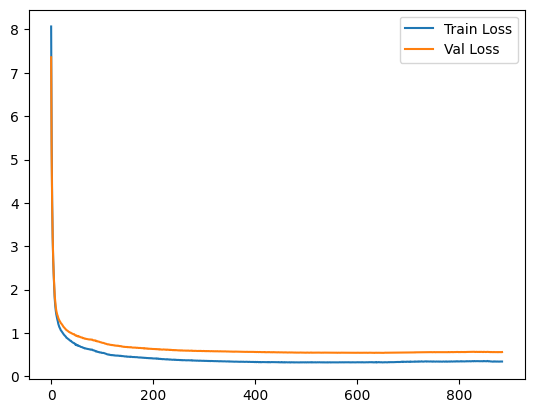

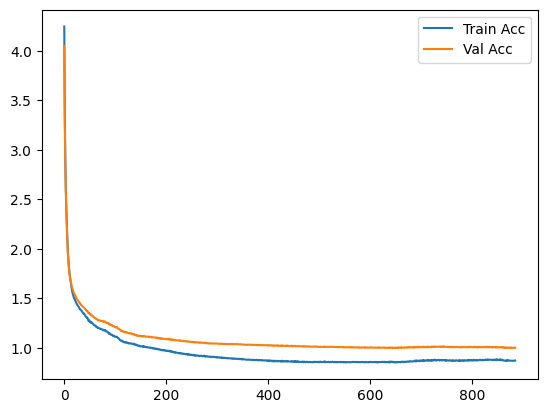

Epochs:  11%|█         | 1114/10000 [00:45<06:02, 24.52it/s]


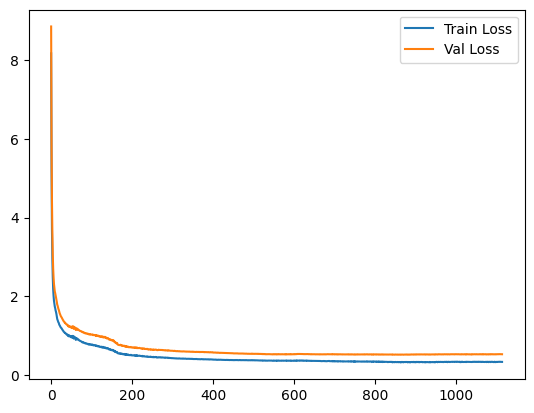

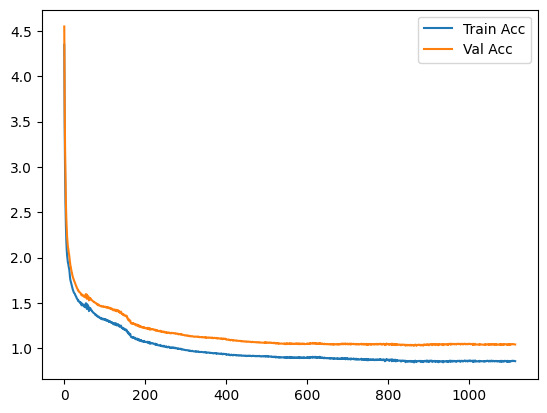

Epochs:  12%|█▏        | 1211/10000 [00:49<06:00, 24.39it/s]


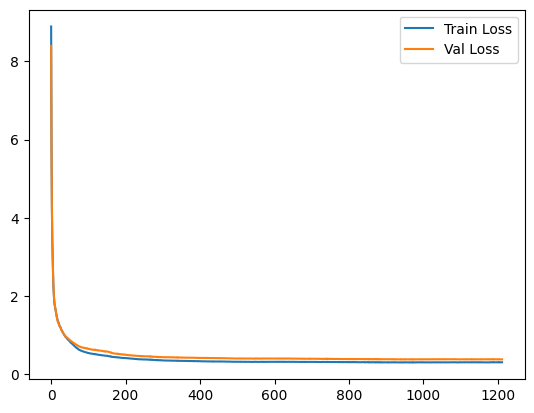

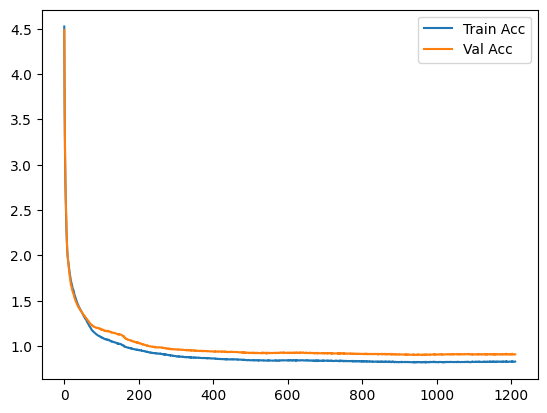

Epochs:  17%|█▋        | 1680/10000 [01:08<05:41, 24.37it/s]


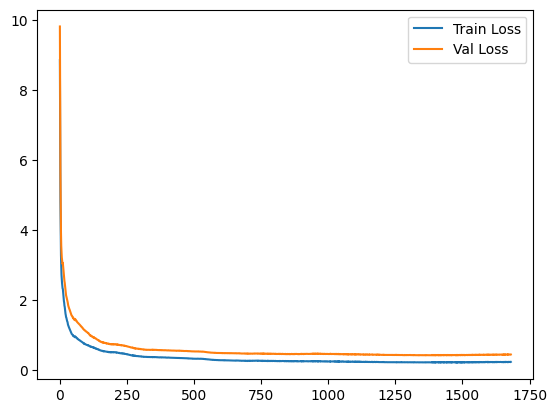

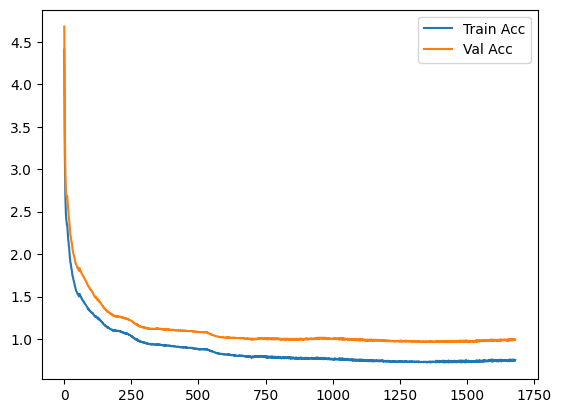

Epochs:  13%|█▎        | 1270/10000 [00:51<05:56, 24.46it/s]


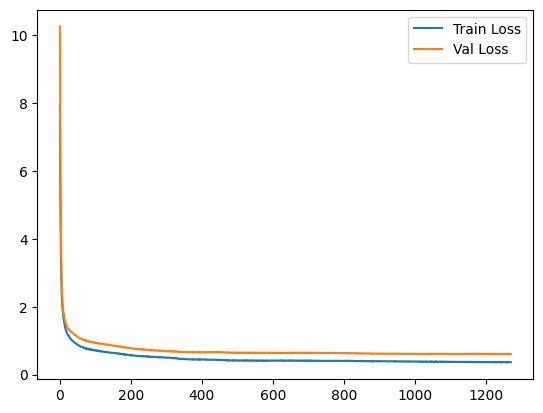

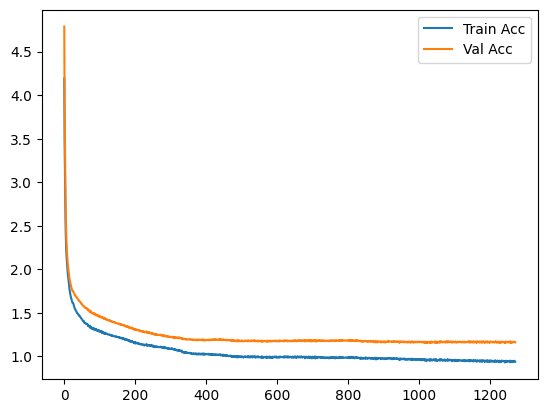

{'tr_loss': 0.3032780573081916, 'tr_metric': 0.8396317248388497, 'val_loss': 0.4827593641784576, 'val_metric': 1.0113244327440276}






Epochs:  17%|█▋        | 1722/10000 [01:05<05:16, 26.16it/s]


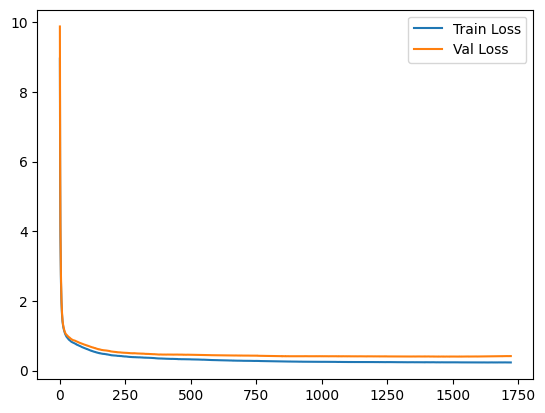

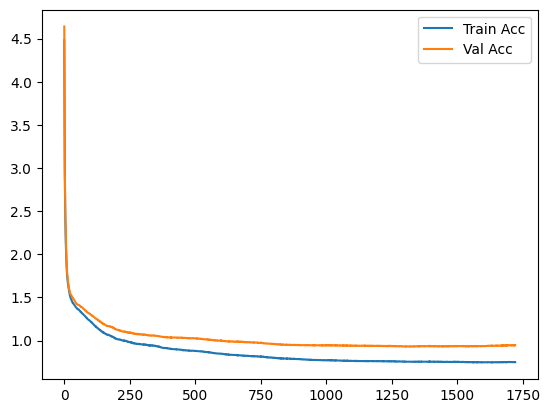

Epochs:  36%|███▌      | 3615/10000 [02:25<04:17, 24.81it/s]


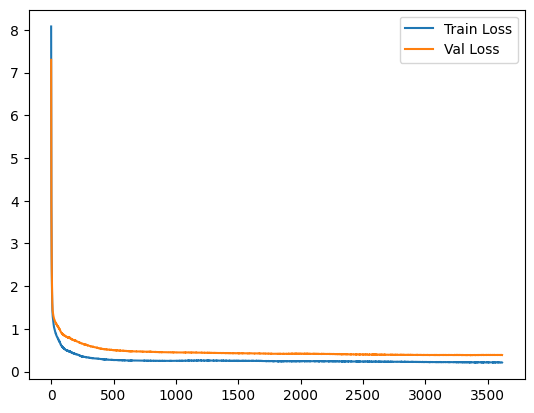

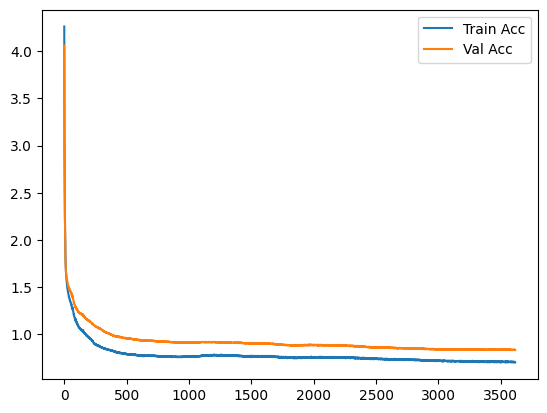

Epochs:  21%|██▏       | 2128/10000 [01:25<05:17, 24.79it/s]


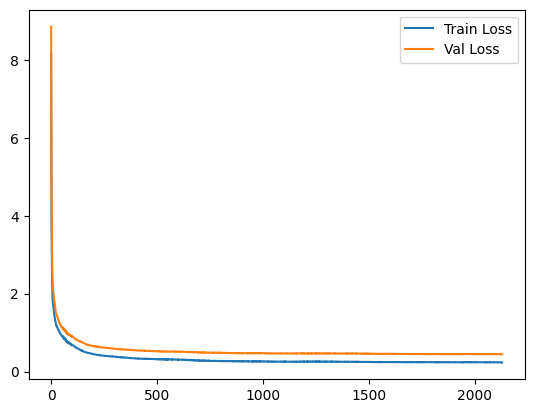

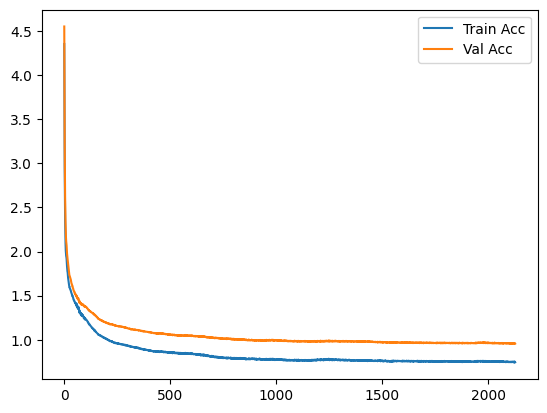

Epochs:  28%|██▊       | 2776/10000 [01:46<04:37, 26.06it/s]


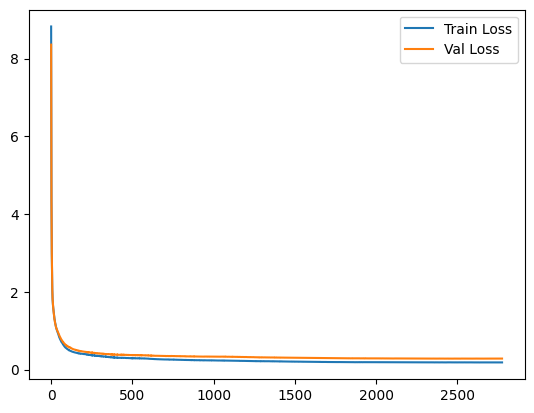

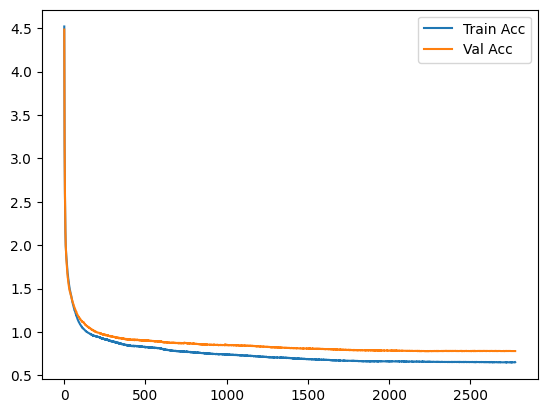

Epochs:  14%|█▎        | 1353/10000 [00:51<05:27, 26.42it/s]


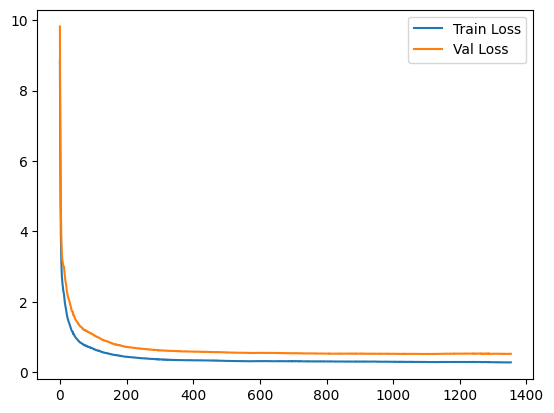

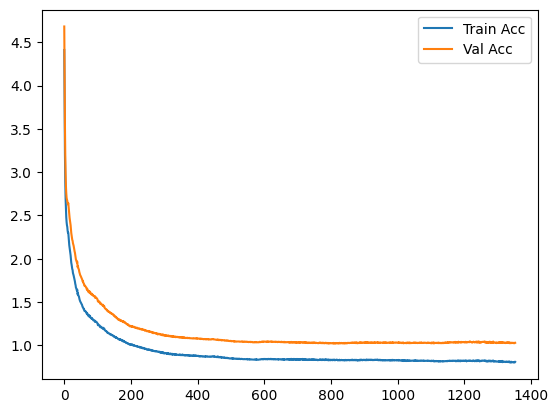

Epochs:  26%|██▌       | 2600/10000 [01:40<04:44, 25.97it/s]


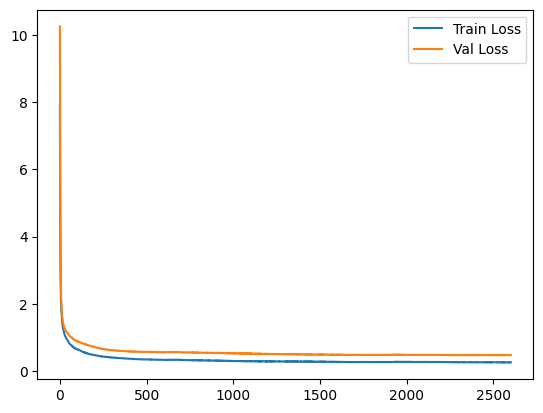

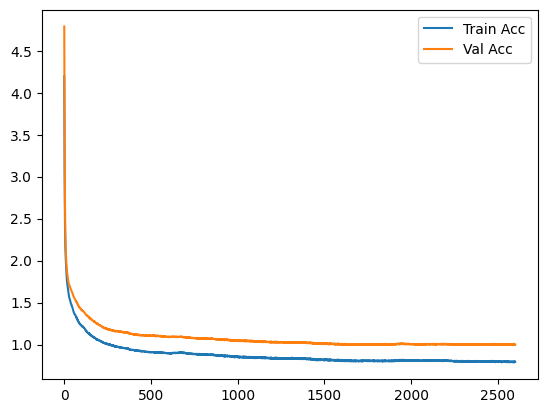

{'tr_loss': 0.237438663473006, 'tr_metric': 0.743783796963581, 'val_loss': 0.41626918903177496, 'val_metric': 0.9195258214007667}






Epochs:   5%|▌         | 549/10000 [00:20<05:52, 26.82it/s]


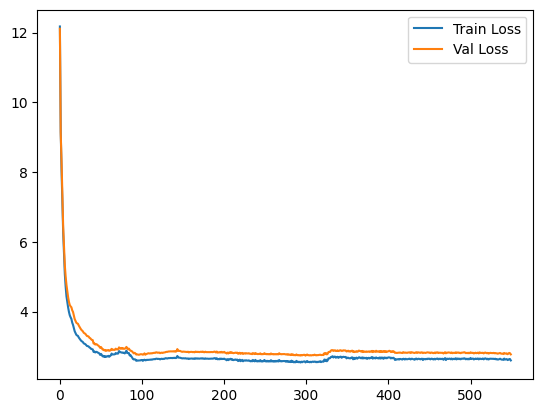

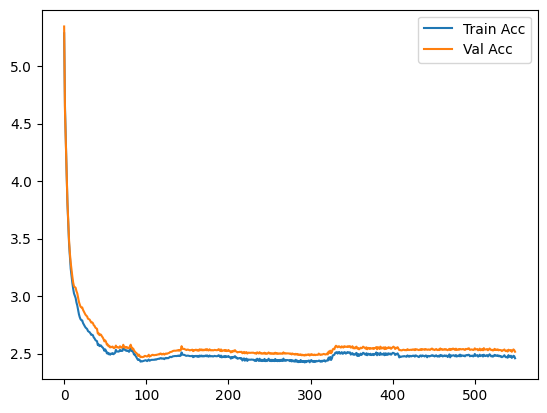

Epochs:   4%|▎         | 369/10000 [00:13<05:55, 27.09it/s]


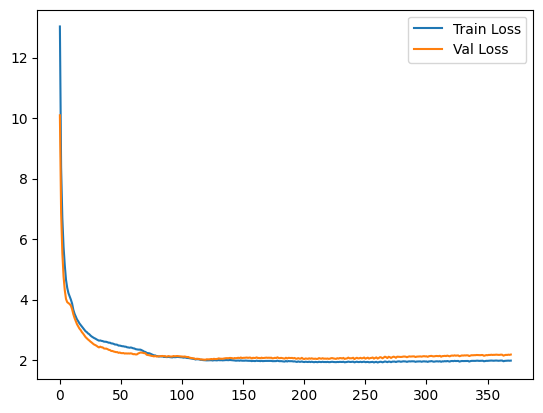

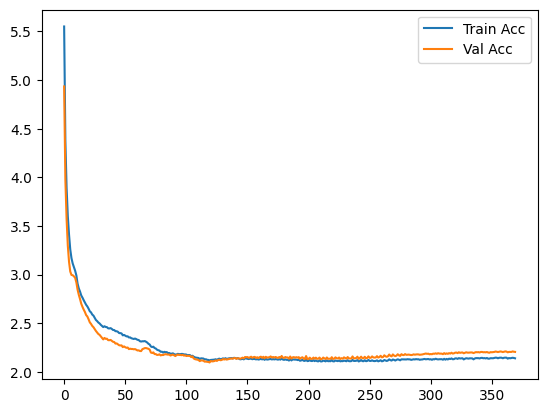

Epochs:  16%|█▌        | 1615/10000 [01:33<08:04, 17.30it/s]


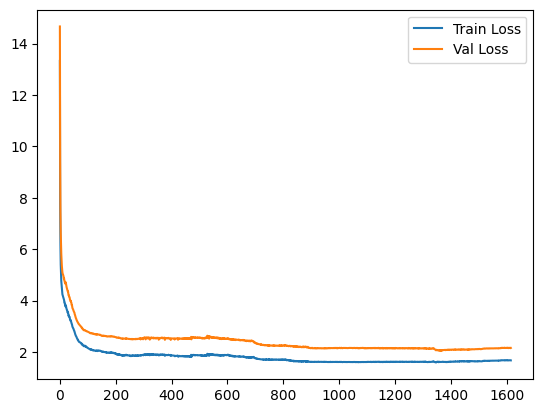

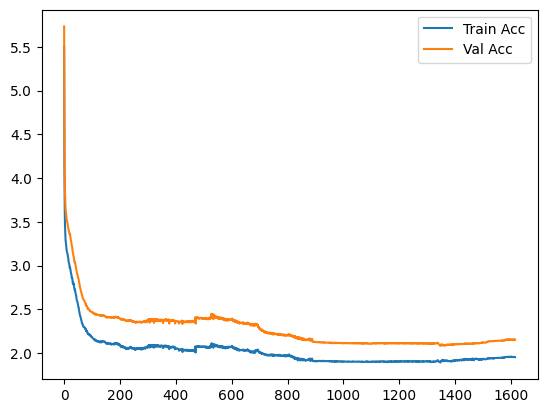

Epochs:   5%|▍         | 466/10000 [00:27<09:20, 17.01it/s]


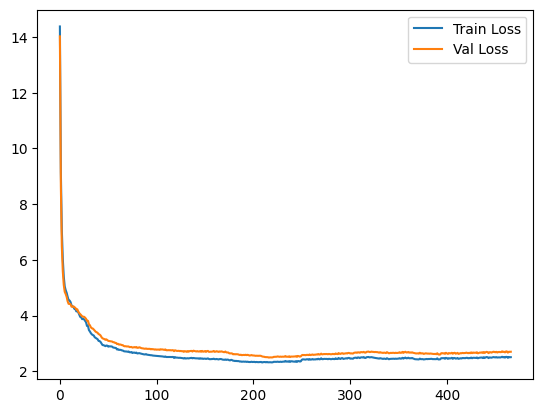

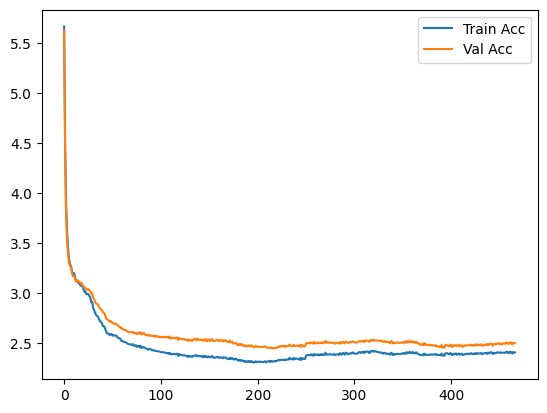

Epochs:   7%|▋         | 747/10000 [00:44<09:08, 16.86it/s]


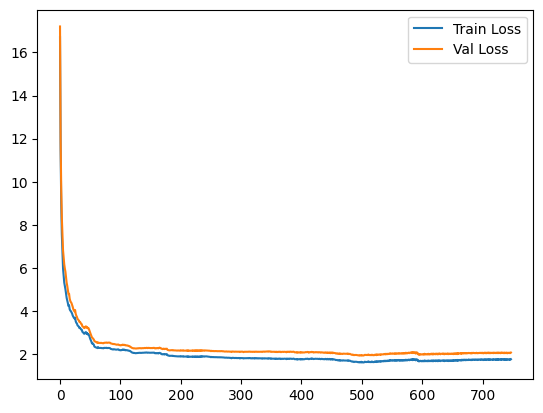

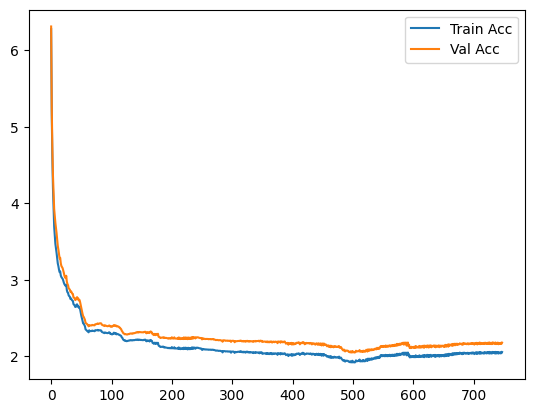

Epochs:   6%|▌         | 602/10000 [00:35<09:19, 16.81it/s]


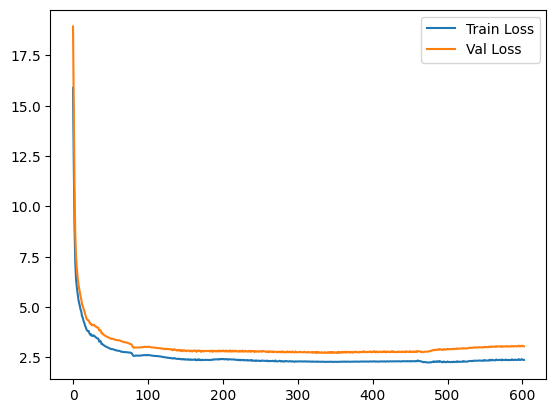

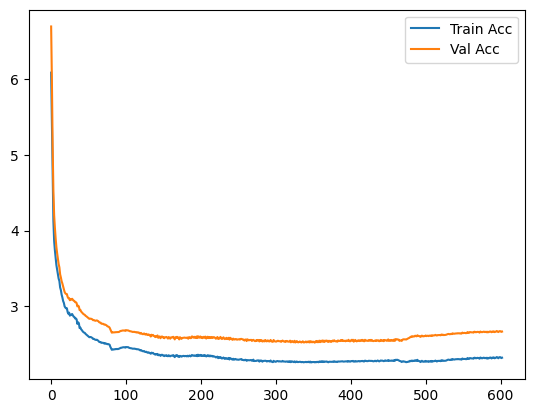

{'tr_loss': 2.0587136878397323, 'tr_metric': 2.1584244670072796, 'val_loss': 2.3238553905061057, 'val_metric': 2.280603853662235}






Epochs:   6%|▋         | 639/10000 [00:37<09:03, 17.24it/s]


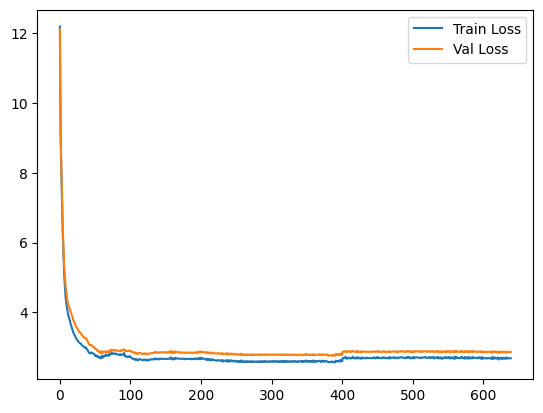

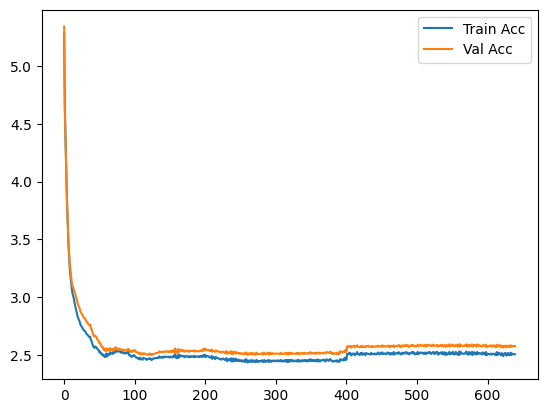

Epochs:   4%|▎         | 363/10000 [00:21<09:18, 17.26it/s]


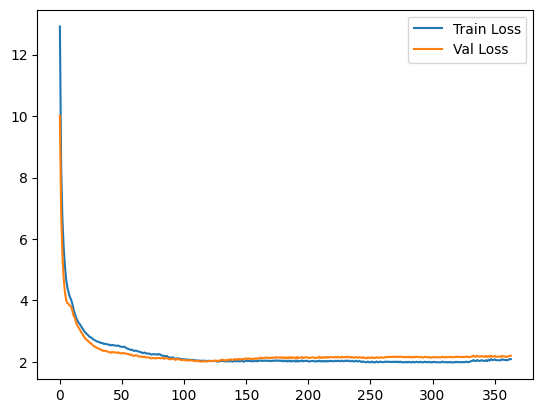

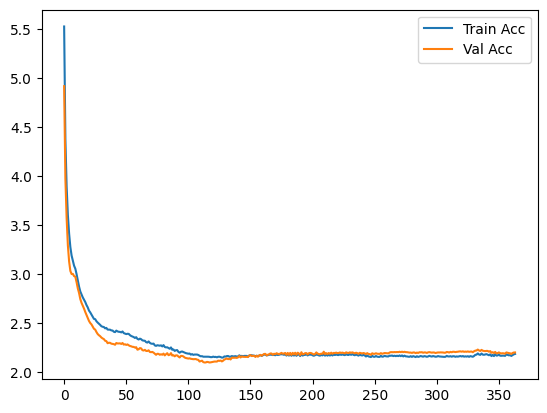

Epochs:   9%|▊         | 871/10000 [00:50<08:49, 17.25it/s]


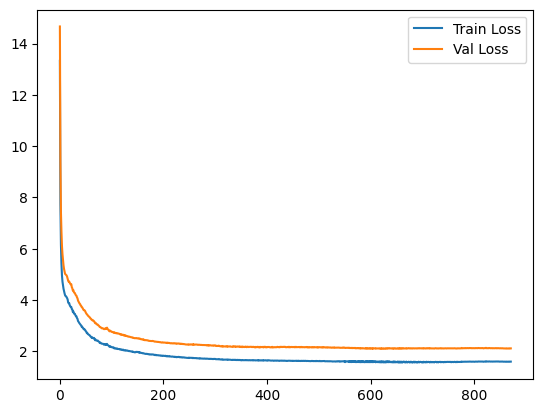

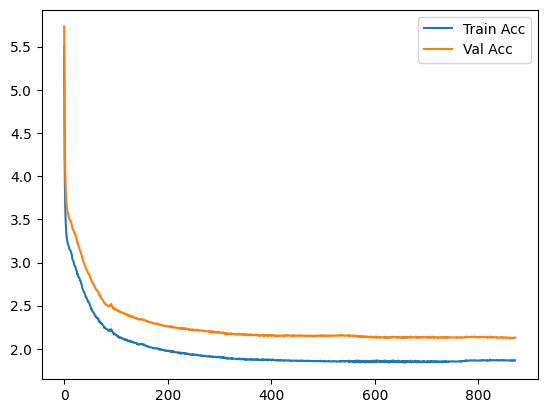

Epochs:   5%|▍         | 473/10000 [00:27<09:10, 17.30it/s]


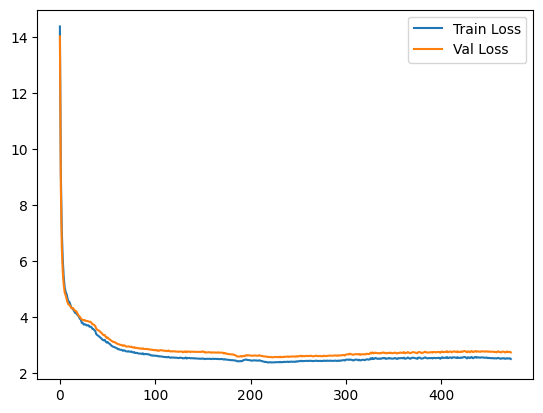

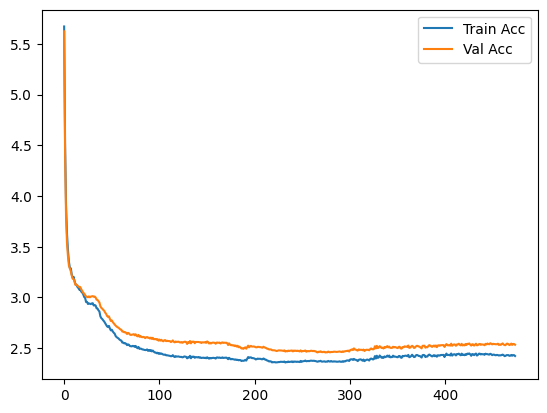

Epochs:   5%|▍         | 451/10000 [00:26<09:11, 17.31it/s]


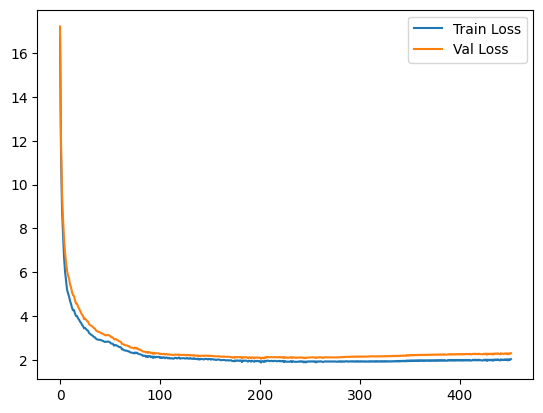

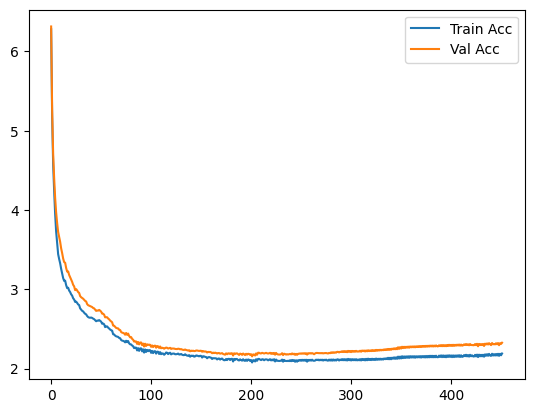

Epochs:   6%|▌         | 621/10000 [00:35<09:01, 17.33it/s]


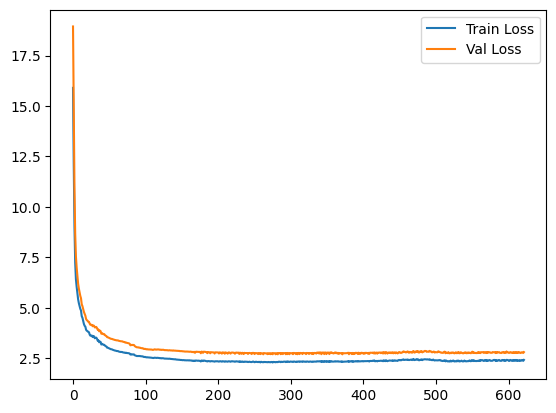

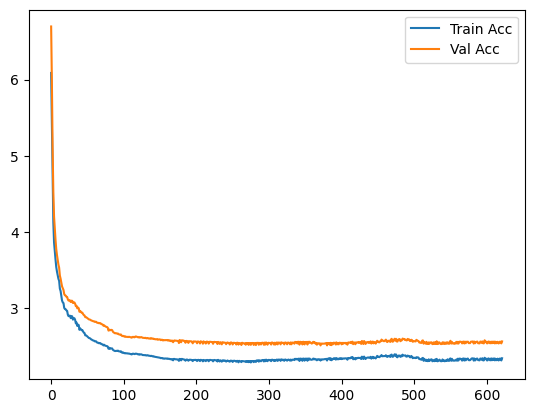

{'tr_loss': 2.125618750400732, 'tr_metric': 2.1976652143021074, 'val_loss': 2.3622420067547645, 'val_metric': 2.310596345004446}






In [39]:
seed = 3
data_to_csv = [[]]
losses_ = "MSE"

for combination in all_dics:
    layers_sizes_ = combination['layers_sizes']
    activations_ = []
    startings_ = []
    startings_range_ = []
    regularizers_ = []
    regularizers_lambda_ = []
    momentums_ = []
    etas_ = combination['etas']
    for i in range(len(combination['layers_sizes'])):
        activations_.append(combination['activations'] if i != len(layers_sizes_)-1 else "Identity")
        startings_.append(combination['startings'])
        startings_range_.append(combination['startings_range'])
        regularizers_.append(combination['regularizers'])
        regularizers_lambda_.append(combination['regularizers_lambda'])
        momentums_.append(combination['momentums'])
    net = create_all_net(
        seed=seed,
        loss="MSE",
        batch_size=1,
        input_size=len(X_train[0]),
        num_layer=len(layers_sizes_),
        layers_size=layers_sizes_,
        activations=activations_,
        starting=startings_,
        starting_range=startings_range_,
        regularizers=regularizers_,
        regularizers_lambda=regularizers_lambda_,
        momentums=momentums_,
        eta=etas_
        )
    statistics = kfold_crossval(
        X=X_train,
        y=y_train,
        k=6,
        net=net,
        epochs=10000,
        patience=250,
        seed=seed,
        metric=MEE(),
        comb=combination
        )
    print(statistics)
    print("\n\n\n")
    data_to_csv.append(list(combination.values()) + list(statistics.values()))


In [40]:
import csv

csv_file_path = '../statistics/test.csv'
with open(csv_file_path, mode='a', newline='') as file:
    writer = csv.writer(file)
    # Write the data to the CSV file
    for row in data_to_csv:
        writer.writerow(row)    